# Critical memory capacity

In [2]:
# -*- coding: utf-8 -*-
from __future__ import division, print_function, absolute_import

import numpy as np
import networkx as nx
import pandas as pd
import random

import sys
sys.path.append('/home/sol/Escritorio/paper_reservoir/')


from reservoir_tools.utils import get_spectral_radius, nrmse, bisection, get_args_index, is_number
from reservoir_tools.control_graphs import control_graphs, randomize_network
from reservoir_tools.datasets import narma10, narma30
from reservoir_tools.tasks import memory_capacity, critical_memory_capacity
from reservoir_tools.readouts import LinearRegression, RidgeRegression
from reservoir_tools.reservoirs import simulate_reservoir_dynamics, remove_node
from reservoir_tools import grn_networks
from reservoir_tools import network_tools as nt
from reservoir_tools.network_statistics import average_degree, connectivity_fraction

In [3]:
GRN_systems = [grn for index, grn in enumerate(grn_networks.grn_names)
                   if grn.lower()=='ecocyc']
graph = grn_networks.load_network(GRN_systems[0])
graph = nt.prune_graph(graph, verbose=1)

Deleted nodes: 3064 (23 roots, 3041 leaves)
Deleted nodes: 95 (2 roots, 93 leaves)
Deleted nodes: 14 (0 roots, 14 leaves)
Deleted nodes: 2 (0 roots, 2 leaves)
Deleted nodes: 1 (0 roots, 1 leaves)


In [28]:
random.seed(420)
np.random.seed(420)
size = graph.number_of_nodes() # 70
SR_scale = 0.9
num_inputs = float('0.66')
if num_inputs < 1:  # it cannot be the number of inputs
    num_inputs *= size  # so it must mean the proportion
num_inputs = int(num_inputs)
inputs_arr = np.sign(np.random.rand(size, 1) - 0.5) # -1, +1
inputs_arr[num_inputs:] = 0 # -1, +1, 0
rand_inputs = True
num_trials = 30
adj_matrix = nx.adjacency_matrix(graph).todense()
if isinstance(adj_matrix, nx.Graph):
    adj_matrix = nx.adjacency_matrix(adj_matrix).todense()
adj_matrix = np.asarray(adj_matrix)

In [4]:
results = []
while len(results) < num_trials:
    if rand_inputs:
        np.random.shuffle(inputs_arr)
    # generate dataset
    sample_len = 1000
    nsamples = 10
    prngI = np.random.RandomState(42)
    input_signal = [(prngI.rand(sample_len, 1)*2-1) for i in range(nsamples)]
    # echo state property
    weights = adj_matrix * (np.random.random(adj_matrix.shape)*2-1)
    spectral_radius = get_spectral_radius(weights)
    weights *= SR_scale / spectral_radius
    # input
    in_scaling = 0.05
    in_weight = inputs_arr * in_scaling
    # Run WT dynamics (for training)
    res_dynamics = [simulate_reservoir_dynamics(weights.T, in_weight.T,
                                                    i_sig.ravel())
                        for i_sig in input_signal]

    results.append(critical_memory_capacity(input_signal, res_dynamics))
    print(len(results))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [5]:
np.mean(results)

15.5

# Vario el spectral radius 

In [4]:
random.seed(420)
np.random.seed(420)
size = graph.number_of_nodes() # 70
#SR_scale = 0.9
num_inputs = float('0.66')
if num_inputs < 1:  # it cannot be the number of inputs
    num_inputs *= size  # so it must mean the proportion
num_inputs = int(num_inputs)
inputs_arr = np.sign(np.random.rand(size, 1) - 0.5) # -1, +1
inputs_arr[num_inputs:] = 0 # -1, +1, 0
rand_inputs = True
num_trials = 500
adj_matrix = nx.adjacency_matrix(graph).todense()
if isinstance(adj_matrix, nx.Graph):
    adj_matrix = nx.adjacency_matrix(adj_matrix).todense()
adj_matrix = np.asarray(adj_matrix)

C:\Users\Maria\AppData\Local\Temp\ipykernel_15732\3909231209.py:13: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(graph).todense()


In [5]:
array_SR_values = np.linspace(0.1, 1.9, 20)
prngI = np.random.RandomState(42)

num_trials = 500
results = np.zeros(20)
all_experiments = []
a = 0



while a < num_trials:
    if rand_inputs:
        np.random.shuffle(inputs_arr)
    # generate dataset
    sample_len = 1000
    nsamples = 10
    input_signal = [(prngI.rand(sample_len, 1)*2-1) for i in range(nsamples)]
    # echo state property
    weights = adj_matrix * (np.random.random(adj_matrix.shape)*2-1)
    
    # input
    in_scaling = 0.05
    in_weight = inputs_arr * in_scaling
    mem_capac_spectral = []
    for SR_scale in array_SR_values:
        spectral_radius = get_spectral_radius(weights)
        weights *= SR_scale / spectral_radius
        
        # Run WT dynamics (for training)
        res_dynamics = [simulate_reservoir_dynamics(weights.T, in_weight.T,
                                                        i_sig.ravel())
                            for i_sig in input_signal]

        mem_capac_spectral.append(critical_memory_capacity(input_signal, res_dynamics))
    results += np.array(mem_capac_spectral)
    all_experiments.append(mem_capac_spectral)
    a+=1
    print(a)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [6]:
desviaciones = []
mean = []
for i in range(len(all_experiments[0])):
    results = []
    for experiment in all_experiments:
        results.append(experiment[i])
    desviaciones.append(np.std(results))
    mean.append(np.mean(results))

In [12]:
np.savetxt('CriticalMemory_500TRIALS_variedSR.txt', np.c_[array_SR_values, mean, desviaciones])   # x,y,z equal sized 1D arrays


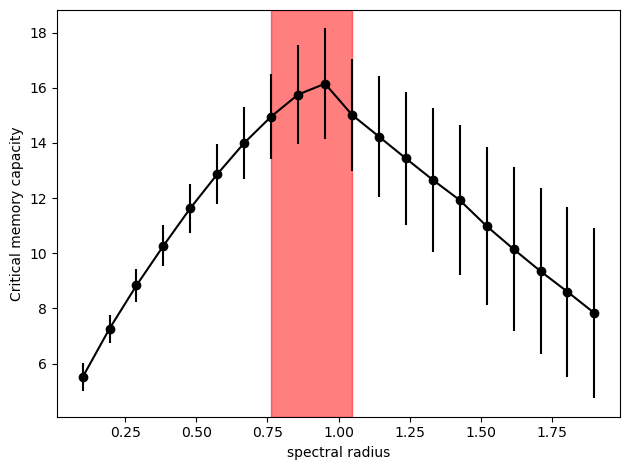

In [11]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots()
plt.plot(array_SR_values , mean, "o", color = "k")
plt.errorbar(array_SR_values, mean, yerr=np.array(desviaciones), label='both limits (default)', color = "k")
plt.axvspan(array_SR_values[int(np.argwhere(mean == max(mean)))-2], array_SR_values[int(np.argwhere(mean == max(mean)))+1], alpha=0.5, color='red')
#plt.axhline(y=0)
#plt.axvline(x=0.95)
plt.ylabel("Critical memory capacity")
plt.xlabel("spectral radius")
plt.tight_layout()
plt.show()

In [30]:
array_SR_values = np.linspace(0.1, 1.9, 20)
prngI = np.random.RandomState(42)
mem_capac_spectral = []
std_dev_res = []
for SR_scale in array_SR_values:
    results = []
    while len(results) < num_trials:
        if rand_inputs:
            np.random.shuffle(inputs_arr)
        # generate dataset
        sample_len = 1000
        nsamples = 10
        input_signal = [(prngI.rand(sample_len, 1)*2-1) for i in range(nsamples)]
        # echo state property
        weights = adj_matrix * (np.random.random(adj_matrix.shape)*2-1)
        spectral_radius = get_spectral_radius(weights)
        weights *= SR_scale / spectral_radius
        # input
        in_scaling = 0.05
        in_weight = inputs_arr * in_scaling
        # Run WT dynamics (for training)
        res_dynamics = [simulate_reservoir_dynamics(weights.T, in_weight.T,
                                                        i_sig.ravel())
                            for i_sig in input_signal]

        results.append(critical_memory_capacity(input_signal, res_dynamics))
    mem_capac_spectral.append(np.mean(results))
    std_dev_res.append(np.std(results))
    print(len(mem_capac_spectral))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


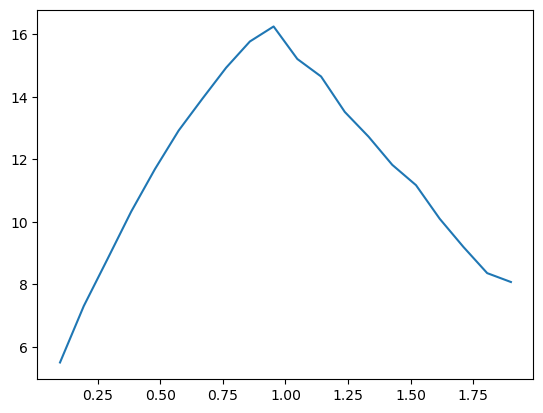

In [21]:
import matplotlib.pyplot as plt 
plt.plot(array_SR_values , mem_capac_spectral)

<ErrorbarContainer object of 3 artists>

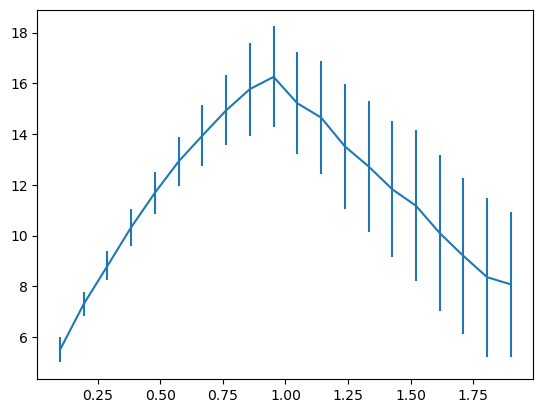

In [31]:
import matplotlib.pyplot as plt 
plt.errorbar(array_SR_values, mem_capac_spectral, yerr=np.array(std_dev_res), label='both limits (default)')
#plt.plot(array_SR_values , mem_capac_spectral)

In [32]:
np.savetxt('CriticalMemory_500TRIALS_variedSR.txt', np.c_[array_SR_values,mem_capac_spectral,std_dev_res])   # x,y,z equal sized 1D arrays

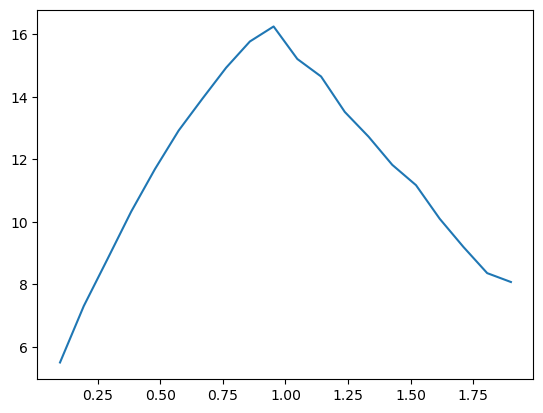

In [25]:
import matplotlib.pyplot as plt 
plt.plot(array_SR_values , mem_capac_spectral)

In [13]:
np.argwhere(mem_capac_spectral==max(mem_capac_spectral))

array([[9]])

In [16]:
array_SR_values[np.argwhere(mem_capac_spectral==max(mem_capac_spectral))]

array([[0.95263158]])

# Variar input coupling

In [36]:
# -*- coding: utf-8 -*-
from __future__ import division, print_function, absolute_import

import numpy as np
import networkx as nx
import pandas as pd
import random

import sys
sys.path.append('/home/sol/Escritorio/paper_reservoir/')


from reservoir_tools.utils import get_spectral_radius, nrmse, bisection, get_args_index, is_number
from reservoir_tools.control_graphs import control_graphs, randomize_network
from reservoir_tools.datasets import narma10, narma30
from reservoir_tools.tasks import memory_capacity, critical_memory_capacity
from reservoir_tools.readouts import LinearRegression, RidgeRegression
from reservoir_tools.reservoirs import simulate_reservoir_dynamics, remove_node
from reservoir_tools import grn_networks
from reservoir_tools import network_tools as nt
from reservoir_tools.network_statistics import average_degree, connectivity_fraction

In [37]:
GRN_systems = [grn for index, grn in enumerate(grn_networks.grn_names)
                   if grn.lower()=='ecocyc']
graph = grn_networks.load_network(GRN_systems[0])
graph = nt.prune_graph(graph, verbose=1)

Deleted nodes: 3064 (23 roots, 3041 leaves)
Deleted nodes: 95 (2 roots, 93 leaves)
Deleted nodes: 14 (0 roots, 14 leaves)
Deleted nodes: 2 (0 roots, 2 leaves)
Deleted nodes: 1 (0 roots, 1 leaves)


In [38]:
random.seed(420)
np.random.seed(420)
size = graph.number_of_nodes() # 70
#SR_scale = 0.9
num_inputs = float('0.66')
if num_inputs < 1:  # it cannot be the number of inputs
    num_inputs *= size  # so it must mean the proportion
num_inputs = int(num_inputs)
inputs_arr = np.sign(np.random.rand(size, 1) - 0.5) # -1, +1
inputs_arr[num_inputs:] = 0 # -1, +1, 0
rand_inputs = True
num_trials = 500
adj_matrix = nx.adjacency_matrix(graph).todense()
if isinstance(adj_matrix, nx.Graph):
    adj_matrix = nx.adjacency_matrix(adj_matrix).todense()
adj_matrix = np.asarray(adj_matrix)

In [39]:
array_input_coupling = np.linspace(0.01, 0.40, 20)
prngI = np.random.RandomState(42)
mem_capac_spectral = []
std_dev_res = []
SR_scale = 0.750
for in_scaling in array_input_coupling:
    results = []
    while len(results) < num_trials:
        if rand_inputs:
            np.random.shuffle(inputs_arr)
        # generate dataset
        sample_len = 1000
        nsamples = 10
        input_signal = [(prngI.rand(sample_len, 1)*2-1) for i in range(nsamples)]
        # echo state property
        weights = adj_matrix * (np.random.random(adj_matrix.shape)*2-1)
        spectral_radius = get_spectral_radius(weights)
        weights *= SR_scale / spectral_radius
        # input
        #in_scaling = 0.05
        in_weight = inputs_arr * in_scaling
        # Run WT dynamics (for training)
        res_dynamics = [simulate_reservoir_dynamics(weights.T, in_weight.T,
                                                        i_sig.ravel())
                            for i_sig in input_signal]

        results.append(critical_memory_capacity(input_signal, res_dynamics))
    mem_capac_spectral.append(np.mean(results))
    std_dev_res.append(np.std(results))
    print(len(mem_capac_spectral))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


<ErrorbarContainer object of 3 artists>

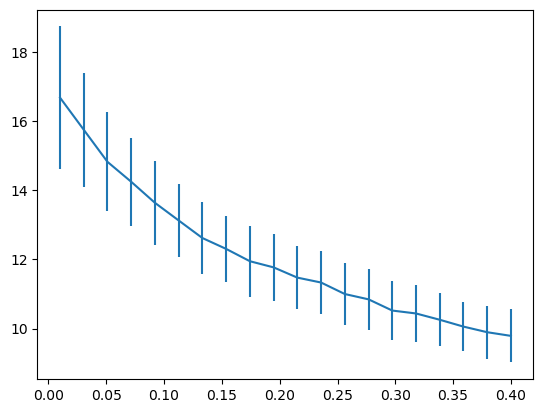

In [40]:
import matplotlib.pyplot as plt 
plt.errorbar(array_input_coupling, mem_capac_spectral, yerr=np.array(std_dev_res), label='both limits (default)')
#plt.plot(array_SR_values , mem_capac_spectral)

In [48]:
array_input_coupling = np.linspace(0.01, 1.0, 20)
prngI = np.random.RandomState(42)

num_trials = 500
results = np.zeros(20)
all_experiments = []
a = 0

SR_scale = 0.950

while a < num_trials:
    if rand_inputs:
        np.random.shuffle(inputs_arr)
    # generate dataset
    sample_len = 1000
    nsamples = 10
    input_signal = [(prngI.rand(sample_len, 1)*2-1) for i in range(nsamples)]
    # echo state property
    weights = adj_matrix * (np.random.random(adj_matrix.shape)*2-1)
    spectral_radius = get_spectral_radius(weights)
    weights *= SR_scale / spectral_radius
    # input
    #in_scaling = 0.05
    mem_capac_spectral = []
    for in_scaling in array_input_coupling:
        in_weight = inputs_arr * in_scaling
        # Run WT dynamics (for training)
        res_dynamics = [simulate_reservoir_dynamics(weights.T, in_weight.T,
                                                        i_sig.ravel())
                            for i_sig in input_signal]

        mem_capac_spectral.append(critical_memory_capacity(input_signal, res_dynamics))
    results += np.array(mem_capac_spectral)
    all_experiments.append(mem_capac_spectral)
    a+=1
    print(a)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [49]:
desviaciones = []
mean = []
for i in range(len(all_experiments[0])):
    results = []
    for experiment in all_experiments:
        results.append(experiment[i])
    desviaciones.append(np.std(results))
    mean.append(np.mean(results))

<ErrorbarContainer object of 3 artists>

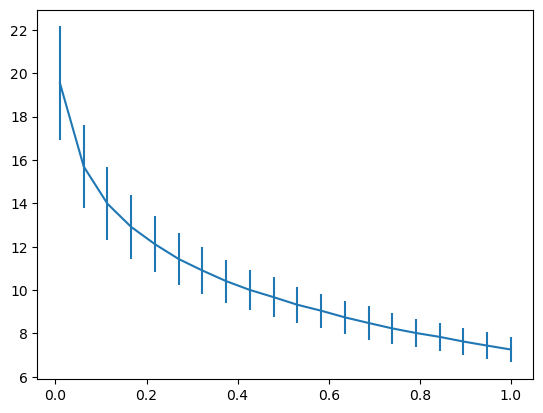

In [50]:
import matplotlib.pyplot as plt 
#plt.plot(array_SR_values , mean)
plt.errorbar(array_input_coupling, mean, yerr=np.array(desviaciones), label='both limits (default)')
#plt.axhline(y=0)
#plt.axvline(x=0.95)